In [3]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import csv
import textwrap

import os, shutil
import numpy as np
import csv
import pandas as pd

import torch
#from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AutoTokenizer, AutoModel

In [4]:
import preprocess_for_context_atlas

/usr/local/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

device :  cpu


In [5]:
# initialize BERT model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device : ", device)

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
model = model.to(device)



device :  cpu


### Choose the word we want to visualize

In [6]:
corpus = "acl"
word = "human"

In [8]:
df = pd.read_csv('./collected_tokens/{}/{}.csv'.format(corpus,word))
df.head(5)

,Unnamed: 0,corpus_id,sentence,start_idx,end_idx
0,0,18022704,"In level 1, ""A"", denotes the semantic class of...",13,14
1,1,18022704,"Accroding to human intuition, they simply refe...",2,3
2,2,16703040,"Second, because the thread source did not requ...",9,10
3,3,16703040,"7 With the RB corpus, the best performing sin...",24,25
4,4,16703040,"Finally, our classifier cannot out-perform hum...",21,22


In [11]:
sentences_w_word = df

# get setneces that are less than 150 in length
sentences_w_word[
    sentences_w_word["sentence"].apply(lambda x: len(x) > 120)
]

####### REAL ######
# Take at most 200 sentences.
# sentences_w_word = sentences_w_word.sample(500)

##### DEBUG########
# Take at most 2 sentences.
sentences_w_word = sentences_w_word.sample(200)


# convert to list
sentences_w_word = sentences_w_word['sentence'].to_list()



In [12]:
# get the vectors
data = preprocess_for_context_atlas.neighbors(word, sentences_w_word)


Getting embeddings for 200 sentences 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Preprocess returns a dict with three array-containing keys. sentence, pos, and data. Later we can add to this preprocessing if we want to add more metadata. For now, we separate them out. would perhaps be better to put them all in a single df and use that to build our plot. TODO if you go down that road but unnecessary now. That would involve making a DF from the labels and one from the data and joining them together.

In [75]:
sents = [label['sentence'] for label in data['labels'] ]
pos = [label['pos'] for label in data['labels'] ]

print(sents[:2])
print(pos)

['In a similar way to deploying human feedback, extrinsic loss functions have been used to provide learning signals for SMT.', 'The result is a probability distribution P(w k |x i ,C) describing the likelihood that a human speaker will use the term w k to identify a target x i in the context C of a specific set of three patches to be distinguished.']
['JJ', 'JJ', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'X', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'X', 'JJ', 'JJ', 'X', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'X', 'JJ', 'X', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'NN', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'NN', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'X', 'JJ

In [14]:
len(data['data'])

12

these are the layers. We select layer 7 (0 indexed)

In [22]:
layer = 7

points = data['data'][layer]
points = np.array(points)
umap_x = points[:,0]
umap_y = points[:,1]

In [76]:
plot_dict = {"umap_x": umap_x,
             "umap_y": umap_y,
             "pos": pos,
             "sents": sents}
df = pd.DataFrame.from_records(plot_dict)
df.head(5)

,pos,sents,umap_x,umap_y
0,JJ,"In a similar way to deploying human feedback, ...",5.514942,11.049861
1,JJ,The result is a probability distribution P(w k...,5.974151,7.807454
2,JJ,"KING represents the probability, estimated ove...",6.458373,8.126172
3,X,"In the extreme case, a completely random distr...",6.191562,2.726834
4,JJ,Our approach is also distinct in its use of hu...,4.713142,10.198801


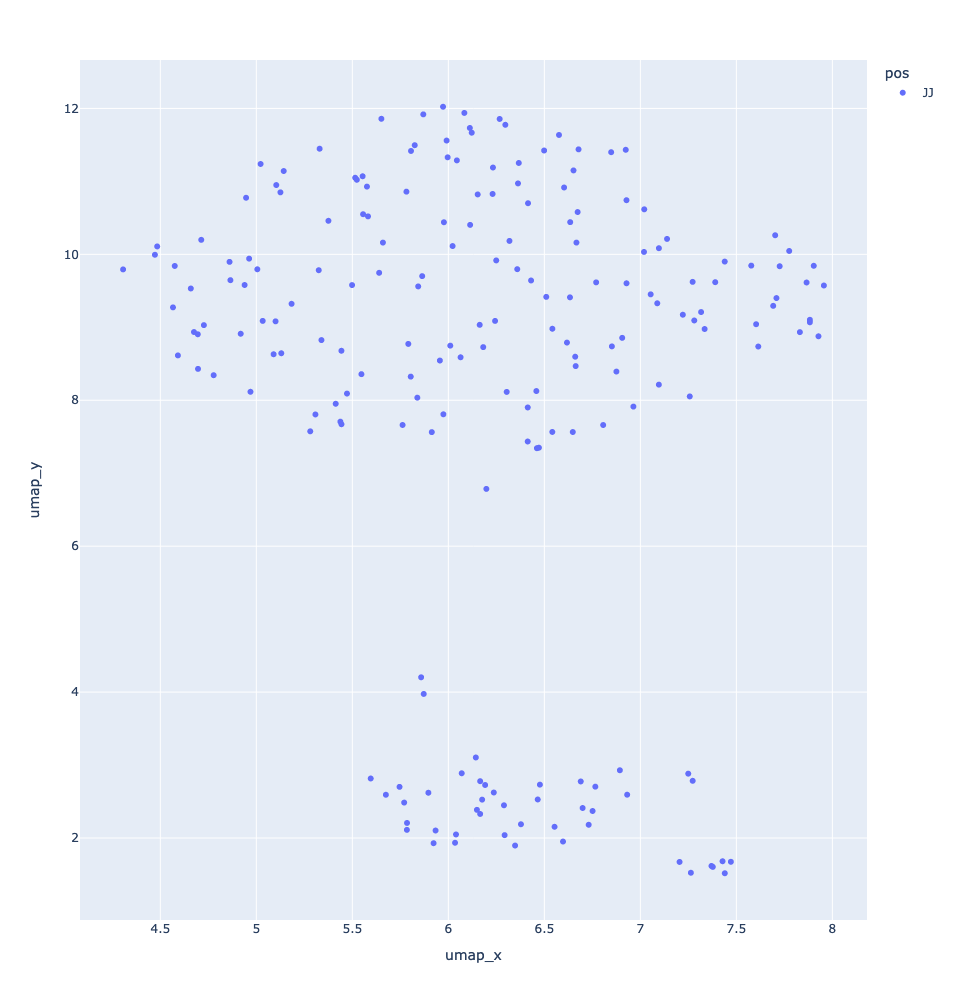

<Figure size 1600x1600 with 0 Axes>

In [52]:
plt.figure(figsize=(16,16))
#plt.figure(figsize=(16,10))

fig = px.scatter(df, x="umap_x", y="umap_y",
                 color="pos", 
                 hover_data="sents",
                 width=1000, height=1000
                )

fig.update_layout(hoverlabel={
    "align": "right",
    "bgcolor": "white"
})
fig.update_layout(hoverlabel_font={
    "size": 9,
    "color": "black"
})



fig.show()

In [53]:
fig.write_html("visualizations/{}_{}_{}.html".format(corpus, word, layer))

In [ ]:
Experiment in doing a dropdown

In [36]:
import plotly.graph_objects as go

In [86]:
pos = [label['pos'] for label in data['labels'] ]

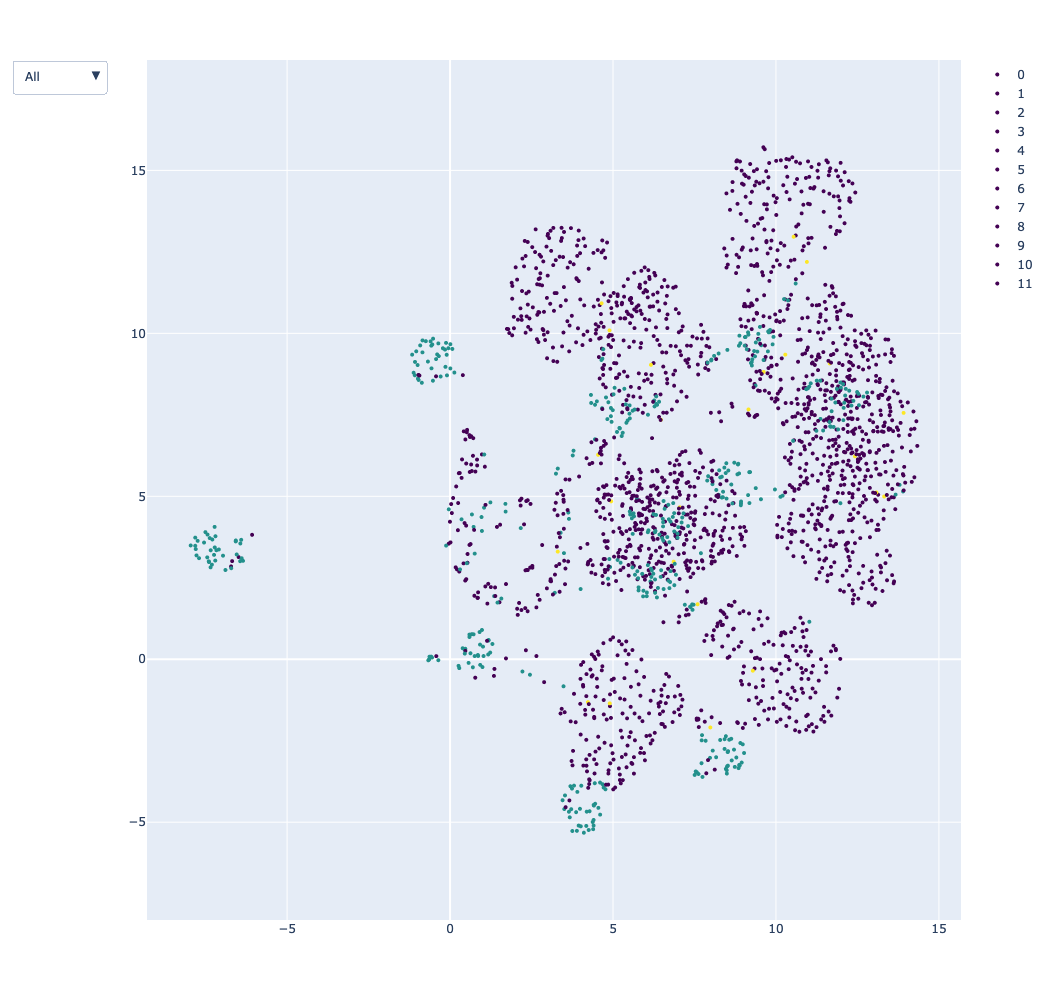

In [89]:
# How to change plot data using dropdowns
#
# This example shows how to manually add traces
# to the plot and configure the dropdown to only
# show the specific traces you allow.

fig = go.Figure()
#plt.figure(figsize=(16,16))

fig = px.scatter(
                #color = df['pos'],
                 width=1000, height=1000
                )

"""
create color list based on POS
"""
#create dict with unique color values
pos = [label['pos'] for label in data['labels'] ]
color_dict={}
x=0
for p in pos:
    if p not in color_dict:
        color_dict[p]=x
        x += 1
        
#create color list
color_list=[]
for p in pos:
    color_list.append(color_dict[p])

"""
create traces for different layers
"""

for layer in range(12):
    points = data['data'][layer]
    points = np.array(points)
    fig.add_trace(
        go.Scatter(
            mode='markers',
            marker=dict(
                    size=4,
                    color=color_list,                # set color to an array/list of desired values
                    colorscale='Viridis',   # choose a colorscale
                    #opacity=0.8
                ),

            x = points[:,0],
            y = points[:,1],
            hovertext=df["sents"],
            
            name = layer
        )
    )

fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )


"""
create dropdown menu to show one set of points at a time
"""
    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'All',
                  method = 'update',
                  args = [{'visible': [True, True, True, True, True, True, True, True, True, True, True, True]},
                          {'title': 'All',
                           'showlegend':True}]),


             
             dict(label = 'Layer 0',
                  method = 'update',
                  args = [{'visible': [True, False, False, False, False, False, False, False, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 0',
                           'showlegend':True}]),
             dict(label = 'Layer 1',
                  method = 'update',
                  args = [{'visible': [False, True, False, False, False, False, False, False, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 1',
                           'showlegend':True}]),
             dict(label = 'Layer 2',
                  method = 'update',
                  args = [{'visible': [False, False, True, False, False, False, False, False, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 2',
                           'showlegend':True}]),
             dict(label = 'Layer 3',
                  method = 'update',
                  args = [{'visible': [False, False, False, True, False, False, False, False, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 3',
                           'showlegend':True}]),
             dict(label = 'Layer 4',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, True, False, False, False, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 4',
                           'showlegend':True}]),
             dict(label = 'Layer 6',
                  method = 'update',
                  args = [{'visible': [True, False, False, False, False, False, True, False, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 6',
                           'showlegend':True}]),
             dict(label = 'Layer 7',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, False, False, False, True, False, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 7',
                           'showlegend':True}]),
              dict(label = 'Layer 8',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, False, False, False, False, True, False, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 8',
                           'showlegend':True}]),
             dict(label = 'Layer 9',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, False, False, False, False, False, True, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 9',
                           'showlegend':True}]),
             dict(label = 'Layer 10',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, False, False, False, False, False, False, True, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 10',
                           'showlegend':True}]),
             dict(label = 'Layer 11',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, False, False, False, False, False, False, False, True]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Layer 11',
                           'showlegend':True}]),

            ])
        )
    ])

fig.update_layout(hoverlabel={
    "align": "right",
    "bgcolor": "white"
})
fig.update_layout(hoverlabel_font={
    "size": 9,
    "color": "black"
})


fig.show()

### 

0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Name: colors, Length: 150, dtype: int64


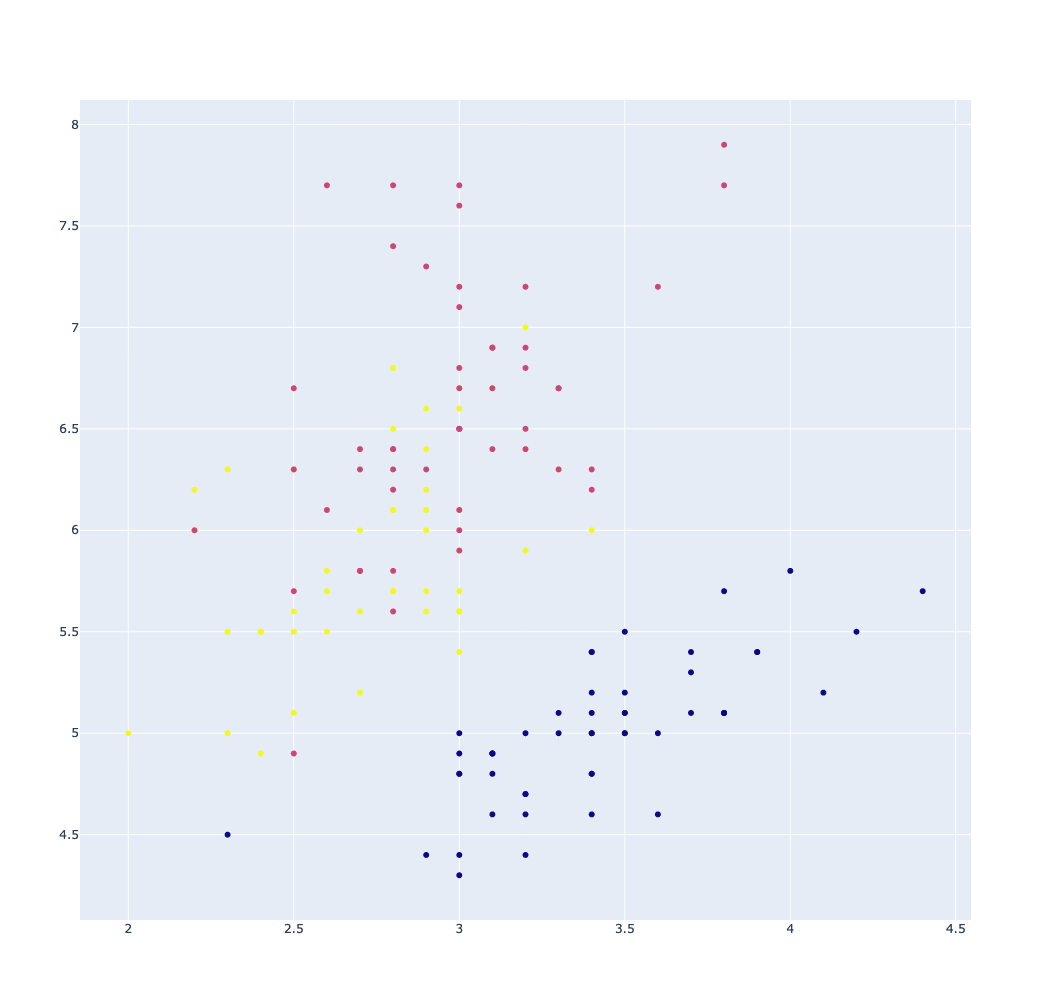

In [65]:
import plotly.express as px
import plotly.graph_objects as go

df_iris = px.data.iris()
df_iris['colors'] = df_iris['species'].apply(lambda x: 1 if x=='setosa' else (2 if x=='virginica' else 3))
print(df_iris.colors)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_iris.sepal_width,
    y=df_iris.sepal_length,
    mode='markers',
    marker=dict(color=df_iris.colors)
))

fig.update_layout(height=1000)
fig.show()